In [1]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss
import pandas as pd
from tqdm.notebook import tqdm
import os, re, math

In [2]:
%cd ../paper
%pwd

[Errno 2] No such file or directory: '../paper'
/home/kuenico/dev/rofl-project-code/plots/ref_v1


'/home/kuenico/dev/rofl-project-code/plots/ref_v1'

In [6]:
# PAPER_DIR = "./../../fl-project"
PAPER_DIR = "./.."

output_dir = PAPER_DIR + "/plots"

#pd.set_option('display.max_columns', 500)
#pd.set_option('display.max_rows', 500)

def setup_plt():

    fig_width_pt = 220  # Get this from LaTeX using \showthe
    inches_per_pt = 1.0 / 72.27 * 2  # Convert pt to inches
    golden_mean = ((np.math.sqrt(5) - 1.0) / 2.0) * .8  # Aesthetic ratio
    fig_width = fig_width_pt * inches_per_pt  # width in inches
    fig_height = (fig_width * golden_mean)  # height in inches
    fig_size =  [fig_width, fig_height]

    plt_params = {
        'backend': 'ps',
        'axes.labelsize': 20,
        'legend.fontsize': 16,
        'xtick.labelsize': 18,
        'ytick.labelsize': 18,
        'font.size': 18,
        'figure.figsize': fig_size,
        'font.family': 'Times New Roman'
    }

    plt.rcParams.update(plt_params)
    plt.rc('pdf', fonttype=42)  # IMPORTANT to get rid of Type 3


In [4]:

# build benchmarks

cagg_config = {
    "server_label": "aggregate commitment",
    "color": "0.1"
}
wellformed_config = {
    "client_label": "create well-formedness proof",
    "server_label": "verify well-formedness proof",
    "color": "0.3"
}
range_config = {
    "client_label": "create range proof",
    "server_label": "verify range proof",
    "color": "0.5"
}



def extract(filename, pattern, label, data_dir, fixed_point_repr=None):
    # pattern group(1) represents fixed_point_repr
    # pattern group(2) represents n_weights

    lst = []
    match = re.search(pattern, filename, re.IGNORECASE)
    if match:
        # extract the weight parameter and the fp-repr
        group1 = int(match.group(1))

        if fixed_point_repr is None:
            fixed_point_repr = group1
            n_weights = int(match.group(2))
        else:
            fixed_point_repr = fixed_point_repr
            n_weights = group1

        
        # read the benchmark result file
        with open(f"{data_dir}/{filename}", "r") as f:
            lines = f.readlines()
            results =  [int(x) for x in lines]
        
        # go through results and write dicts 
        for i, result in enumerate(results):
            d = {
                "repetition": i,
                "fixed_point_repr" : fixed_point_repr,
                "n_weights": n_weights,
                label: result
            }               

            lst.append(d)
    
    return lst
    


def build_df_mbench_computation():

    df1 = _build_df_mbench_computation(data_dir="./../robust-secure-aggregation/benchmarks_paper/large", cmachine="clientlarge", run_server=True)
    df2 = _build_df_mbench_computation(data_dir="./../robust-secure-aggregation/benchmarks_paper/small", cmachine="clientsmall", run_server=False)

    df = df1.merge(df2)

    return df


def _build_df_mbench_computation(data_dir, cmachine, run_server):

    # 1st loop over all files in folder
    l1 = []
    l2 = []
    l3 = []
    l4 = []
    l5 = []
    l6 = []
    l7 = []
    l8 = []
    l9 = []
    l10 = []

    for filename in os.listdir(data_dir):

        # extract randproof
        pattern = "create-paper-randproof-([0-9]+)-([0-9]+)-.*.bench"
        lst1 = extract(filename=filename, pattern=pattern, label="create_randproof_ms", data_dir=data_dir)
        l1 += lst1

        if run_server:
            pattern = "verify-paper-randproof-([0-9]+)-([0-9]+)-.*.bench"
            lst2 = extract(filename=filename, pattern=pattern, label="verify_randproof_ms", data_dir=data_dir)
            l2 += lst2

        # extract rangeproof
        pattern = "create-paper-rangeproof-([0-9]+)-[0-9]+-([0-9]+)-.*.bench"
        lst3 = extract(filename=filename, pattern=pattern, label="create_rangeproof_ms", data_dir=data_dir)
        l3 += lst3

        if run_server:
            pattern = "verify-paper-rangeproof-([0-9]+)-[0-9]+-([0-9]+)-.*.bench"
            lst4 = extract(filename=filename, pattern=pattern, label="verify_rangeproof_ms", data_dir=data_dir)
            l4 += lst4

        # extract rangeproof l2
        pattern = "create-paper-rangeproof-l2-([0-9]+)-[0-9]+-([0-9]+)-.*.bench"
        lst5 = extract(filename=filename, pattern=pattern, label="create_rangeproofl2_ms", data_dir=data_dir)
        l5 += lst5

        if run_server:
            pattern = "verify-paper-rangeproof-l2-([0-9]+)-[0-9]+-([0-9]+)-.*.bench"
            lst6 = extract(filename=filename, pattern=pattern, label="verify_rangeproofl2_ms", data_dir=data_dir)
            l6 += lst6

        # extract squarerandproof
        pattern = "create-paper-squarerandproof-([0-9]+)-([0-9]+)-.*.bench"
        lst7 = extract(filename=filename, pattern=pattern, label="create_squarerandproof_ms", data_dir=data_dir)
        l7 += lst7

        if run_server:
            pattern = "verify-paper-squarerandproof-([0-9]+)-([0-9]+)-.*.bench"
            lst8 = extract(filename=filename, pattern=pattern, label="verify_squarerandproof_ms", data_dir=data_dir)
            l8 += lst8

        if run_server:
            # extract discrete log
            pattern = "bench_paper_dlog2-([0-9]+)-16-([0-9]+)-.*.bench"
            lst9 = extract(filename=filename, pattern=pattern, label="dlog2_ms", data_dir=data_dir)
            l9 += lst9

            # extract el gamal addition
            pattern = "bench_paper_addelgamal-([0-9]+)-.*.bench"
            lst10 = extract(filename=filename, pattern=pattern, label="elgamal_add_ms", data_dir=data_dir, fixed_point_repr=16)
            l10 += lst10



    # Combine Data from Different Experiments in separate Columns
    df = pd.DataFrame(l1)
    df = df.merge(pd.DataFrame(l3), how="outer")
    df = df.merge(pd.DataFrame(l5), how="outer")
    df = df.merge(pd.DataFrame(l7), how="outer")

    if run_server:
         df = df.merge(pd.DataFrame(l2), how="outer")
         df = df.merge(pd.DataFrame(l4), how="outer")
         df = df.merge(pd.DataFrame(l6), how="outer")
         df = df.merge(pd.DataFrame(l8), how="outer")
         df = df.merge(pd.DataFrame(l9), how="outer")
         df = df.merge(pd.DataFrame(l10), how="outer")


    df = df.sort_values(["fixed_point_repr", "n_weights", "repetition"])


    agg_client_d = {
        'create_randproof_ms':['mean', 'var', 'count'],
        'create_rangeproof_ms':['mean', 'var', 'count'],
        'create_rangeproofl2_ms':['mean', 'var', 'count'],
        'create_squarerandproof_ms':['mean', 'var', 'count'],
    }

    agg_server_d = {
        'verify_randproof_ms':['mean', 'var', 'count'],
        'verify_rangeproof_ms':['mean', 'var', 'count'],
        'verify_rangeproofl2_ms':['mean', 'var', 'count'],
        'verify_squarerandproof_ms':['mean', 'var', 'count'],
        'dlog2_ms': ['mean', 'var', 'count'],
        'elgamal_add_ms': ['mean', 'var', 'count']
    }

    if run_server:
        agg_d = {**agg_client_d, **agg_server_d}
    else:
        agg_d = agg_client_d


    # Aggregate Repetitions into Mean and variance
    df = df.groupby(["fixed_point_repr", "n_weights"], as_index=False).agg(agg_d)

    # convert to flat df
    df.columns = ['_'.join(tup).rstrip('_') for tup in df.columns.values]

    # Construct relevant metrics

    # client wellformedness
    df[f"l2_{cmachine}_wellformed_ms"] = df["create_squarerandproof_ms_mean"]
    df[f"l8_{cmachine}_wellformed_ms"] = df["create_randproof_ms_mean"]
    df[f"l8p_{cmachine}_wellformed_ms"] = df["create_randproof_ms_mean"]

    df[f"l2_{cmachine}_wellformed_ms_std"] = np.sqrt(df["create_squarerandproof_ms_var"])
    df[f"l8_{cmachine}_wellformed_ms_std"] = np.sqrt(df["create_randproof_ms_var"])
    df[f"l8p_{cmachine}_wellformed_ms_std"] = np.sqrt(df["create_randproof_ms_var"])
    
    # server wellformedness
    if run_server:
        df["l2_server_wellformed_ms"] = df["verify_squarerandproof_ms_mean"]
        df["l8_server_wellformed_ms"] = df["verify_randproof_ms_mean"]
        df["l8p_server_wellformed_ms"] = df["verify_randproof_ms_mean"]

        df["l2_server_wellformed_ms_std"] = np.sqrt(df["verify_squarerandproof_ms_var"])
        df["l8_server_wellformed_ms_std"] = np.sqrt(df["verify_randproof_ms_var"])
        df["l8p_server_wellformed_ms_std"] = np.sqrt(df["verify_randproof_ms_var"])

    # client range
    df[f"l2_{cmachine}_range_ms"] = df["create_rangeproofl2_ms_mean"] + df["create_rangeproof_ms_mean"]
    df[f"l8_{cmachine}_range_ms"] = df["create_rangeproof_ms_mean"]
    df[f"l8p_{cmachine}_range_ms"] = df[df["n_weights"] == 8192]["create_rangeproof_ms_mean"].values[0]

    df[f"l2_{cmachine}_range_ms_std"] = np.sqrt(df["create_rangeproofl2_ms_var"] + df["create_rangeproof_ms_var"])
    df[f"l8_{cmachine}_range_ms_std"] = np.sqrt(df["create_rangeproof_ms_var"])
    df[f"l8p_{cmachine}_range_ms_std"] = np.sqrt(df[df["n_weights"] == 8192]["create_rangeproof_ms_var"].values[0])

    # server range
    if run_server:
        df["l2_server_range_ms"] = df["verify_rangeproofl2_ms_mean"] + df["verify_rangeproof_ms_mean"]
        df["l8_server_range_ms"] = df["verify_rangeproof_ms_mean"]
        df["l8p_server_range_ms"] = df[df["n_weights"] == 8192]["verify_rangeproof_ms_mean"].values[0]

        df["l2_server_range_ms_std"] = np.sqrt(df["verify_rangeproofl2_ms_var"] + df["verify_rangeproof_ms_var"])
        df["l8_server_range_ms_std"] = np.sqrt(df["verify_rangeproof_ms_var"])
        df["l8p_server_range_ms_std"] = np.sqrt(df[df["n_weights"] == 8192]["verify_rangeproof_ms_var"].values[0])

    # el gamal aggregation
    if run_server:
        df["l2_server_caggregation_ms"] = df["elgamal_add_ms_mean"]
        df["l8_server_caggregation_ms"] = df["elgamal_add_ms_mean"]
        df["l8p_server_caggregation_ms"] = df["elgamal_add_ms_mean"]

        df["l2_server_caggregation_ms_std"] = np.sqrt(df["elgamal_add_ms_var"])
        df["l8_server_caggregation_ms_std"] = np.sqrt(df["elgamal_add_ms_var"])
        df["l8p_server_caggregation_ms_std"] = np.sqrt(df["elgamal_add_ms_var"])

    # log2 reconstruction
    if run_server:
        df["server_log2reconstruct_ms"] = df["dlog2_ms_mean"]
        df["server_log2reconstruct_ms_std"] = np.sqrt(df["dlog2_ms_var"])


    # filter out the probabilistic checking
    df = df[df["n_weights"]!=8192]

    # project to new columns
    cols = ["n_weights", "fixed_point_repr"]
    new_cols = [col for col in df.columns.values if col.startswith("l2_") or col.startswith("l8_") or col.startswith("l8p_")]
    cols += new_cols 
    if run_server:
        cols += ["server_log2reconstruct_ms", "server_log2reconstruct_ms_std"]
    df = df[cols]


    return df


def format_plot_computation(ax, ind, width, group_labels, ytick_step=50):
    ##########################
    # General Format         
    ##########################
    #ax.set_title("Hello World")

    def legend_without_duplicate_labels(ax):
        handles, labels = ax.get_legend_handles_labels()
        unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        ax.legend(*zip(*unique), loc="best") # 'best', 'upper right', 'upper left', 'lower left', 
                                                # 'lower right', 'right', 'center left',  'center right',
                                                # 'lower center', 'upper center', 'center'
    legend_without_duplicate_labels(ax)

    ax.grid(True, axis="y", linestyle=':', color='0.6', zorder=0, linewidth=1.2)
    
    ##########################
    # Y - Axis Format
    ##########################
    ax.set_ylim(ymin=0, ymax=None)
    ax.set_ylabel("Time [s]")

    ymax = ax.get_ylim()[1]
    ax.set_yticks(np.arange(0, ymax, ytick_step))
    
    ##########################
    # X - Axis Format
    ##########################

    # add 1st axis for norm (l2, l8, l8p)
    xticks = np.append(ind, ind-width, axis=0)
    xticks = np.append(xticks, ind+width, axis=0)
    xticks = np.sort(xticks)
    labels = 4 * ["$L_2$", "$L_{\infty}$", "$L_{\infty}^{(p)}$"]
    ax.set_xticks(xticks)
    ax.set_xticklabels(labels, fontsize=16, rotation=345)


    # add 2nd axis for number of parameters
    ax2 = ax.twiny()
    ax2.set_xticks(ind)
    # $(2^{{{int(math.log(n_weights,2))}}})$
    group_labels = [f"{round(n_weights/1000)}k" for n_weights in group_labels]
    ax2.set_xticklabels(group_labels, rotation=345)
    ax2.xaxis.set_ticks_position('bottom') 
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 36))
    
    ax2.set_xlabel('Number of Parameters')
    ax2.set_xlim(ax.get_xlim())
    ax2.tick_params(axis='both', which='both', length=0)
    ax2.spines['bottom'].set_visible(False)
 

def build_fig_mbench_computation_server_perclient_zkp(df, name="mbench_computation_server_perclient_zkp"):
    setup_plt()


    with PdfPages(f"{output_dir}/{name}.pdf") as pdf:
   
        fig, ax = plt.subplots()

        ##########################
        # Draw all the lines         
        ##########################

        # build ind, width
        ind = np.arange(0, len(df.index)) * 1.2
        width = 0.3  # the width of the bars
    

        # build the barcharts

        for offset, norm in zip([-width, 0, width], ["l2", "l8", "l8p"]):

            ax.bar(ind+offset, df[f"{norm}_server_range_ms"] / 1000, width, 
                        bottom=df[f"{norm}_server_wellformed_ms"] / 1000, label=range_config["server_label"], 
                        color=range_config["color"], edgecolor="black", zorder=2)

            ax.bar(ind+offset, df[f"{norm}_server_wellformed_ms"] / 1000, width, 
                        bottom=df[f"{norm}_server_caggregation_ms"] / 1000, label=wellformed_config["server_label"], 
                        color=wellformed_config["color"], edgecolor="black", zorder=2)

            ax.bar(ind+offset, df[f"{norm}_server_caggregation_ms"] / 1000, width, 
                        bottom=None, label=cagg_config["server_label"], 
                        color=cagg_config["color"], edgecolor="black", zorder=2)
            
            

        # format the computation barchart
        format_plot_computation(ax, ind, width, df["n_weights"])

        
        pdf.savefig(bbox_inches='tight', pad_inches=0)
        plt.close()
    return fig


def build_fig_mbench_computation_client_zkp(df, clientsuffix="small"):

    machine = f"client{clientsuffix}"
    name= f"mbench_computation_{machine}_zkp"

    setup_plt()

    with PdfPages(f"{output_dir}/{name}.pdf") as pdf:
   
        fig, ax = plt.subplots()

        ##########################
        # Draw all the lines         
        ##########################

        # build ind, width
        ind = np.arange(0, len(df.index)) * 1.2
        width = 0.3  # the width of the bars
    

        # build the barcharts

        for offset, norm in zip([-width, 0, width], ["l2", "l8", "l8p"]):

            ax.bar(ind+offset, df[f"{norm}_{machine}_range_ms"] / 1000, width, 
                        bottom=df[f"{norm}_{machine}_wellformed_ms"] / 1000, label=range_config["client_label"], 
                        color=range_config["color"], edgecolor="black", zorder=2)

            ax.bar(ind+offset, df[f"{norm}_{machine}_wellformed_ms"] / 1000, width, 
                        bottom=None, label=wellformed_config["client_label"], 
                        color=wellformed_config["color"], edgecolor="black", zorder=2)

            
        if clientsuffix == "small":
            ytick_step=200
        else:
            ytick_step=50

        # format the computation barchart
        format_plot_computation(ax, ind, width, df["n_weights"], ytick_step=ytick_step)

        
        pdf.savefig(bbox_inches='tight', pad_inches=0)
        plt.close()
    return fig

def build_fig_mbench_computation_server_dlog(df, name="mbench_computation_server_dlog"):

    label = "discrete log reconstruction"
    color = "0.1"
    setup_plt()

    with PdfPages(f"{output_dir}/{name}.pdf") as pdf:
   
        fig, ax = plt.subplots()

        ##########################
        # Draw all the lines         
        ##########################

        # build ind, width
        ind = np.arange(0, len(df.index)) * 1.2
        width = 0.3  # the width of the bars

        ax.bar(ind, df["server_log2reconstruct_ms"] / 1000, width, 
                        label=label, color=color, edgecolor="black", zorder=2)


        ##########################
        # General Format         
        ##########################
        #ax.set_title("Hello World")
        ax.legend(loc="best")   # 'best', 'upper right', 'upper left', 'lower left', 
                                # 'lower right', 'right', 'center left',  'center right', 
                                # 'lower center', 'upper center', 'center'
        ax.grid(True, axis="y", linestyle=':', color='0.6', zorder=0, linewidth=1.2)


        ##########################
        # Y - Axis Format
        ##########################
        ax.set_ylim(ymin=0, ymax=None)
        ax.set_ylabel("Time [s]")
        #ax.set_yticks(yticks)
        #ax.set_yticklabels(labels, fontsize=16, rotation=345)


        ##########################
        # X - Axis Format
        ##########################
        #ax.set_xlim(xmin=0, xmax=None)
        ax.set_xlabel("Number of Parameters")
        ax.set_xticks(ind)
        labels = [f"{round(x/1000)}k" for x in df["n_weights"]]
        ax.set_xticklabels(labels)

        #labels = 4 * ["$L_2$", "$L_{\infty}$", "$L_{\infty}^{(p)}$"]
        #ax.set_xticks(xticks)
        #ax.set_xticklabels(labels, fontsize=16, rotation=345)

        pdf.savefig(bbox_inches='tight', pad_inches=0)
        plt.close()
    return fig


df = build_df_mbench_computation()
df.to_csv("full_including_smallclient.csv")
display(df)

output_dir = PAPER_DIR + "/plots/evaluation"


fig_mbench_computation_server_dlog = build_fig_mbench_computation_server_dlog(df)
print("Server Overall - Discrete Log Reconstruction:")
display(fig_mbench_computation_server_dlog)

fig_mbench_computation_server_perclient_zkp = build_fig_mbench_computation_server_perclient_zkp(df)
print("\nServer per Client - Zero Knowledge Proofs + Aggregation:")
display(fig_mbench_computation_server_perclient_zkp)

fig_mbench_computation_clientlarge_zkp = build_fig_mbench_computation_client_zkp(df, "large")
print("\nClient Large - Zero Knowledge Proofs:")
display(fig_mbench_computation_clientlarge_zkp)


print("\nClient Small - Zero Knowledge Proofs:")
fig_mbench_computation_clientsmall_zkp = build_fig_mbench_computation_client_zkp(df, "small")
display(fig_mbench_computation_clientsmall_zkp)





FileNotFoundError: [Errno 2] No such file or directory: './../robust-secure-aggregation/benchmarks_paper/large'

L8 Bandwidth (infinity norm):


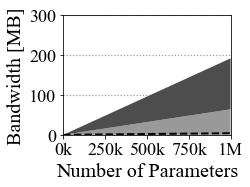


L2 Bandwidth:


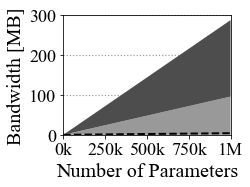

,n_weights,proving_bit_range,n_vector_segments,group_element_bytes,scalar_bytes,plaintext_bytes,l8_commitment_bytes,l2_commitment_bytes,l8_wellformedness_bytes,l2_wellformedness_bytes,l8_range_proof_bytes,l2_range_proof_bytes,l2_total_mb,l8_total_mb
0,1,8,4,32,32,4,64,96,128,192,352.0,736.0,0.001024,0.000544
8,8001,8,4,32,32,32004,512064,768096,1024128,1536192,1184.0,1568.0,2.305856,1.537376
16,16001,8,4,32,32,64004,1024064,1536096,2048128,3072192,1248.0,1632.0,4.609920,3.073440
24,24001,8,4,32,32,96004,1536064,2304096,3072128,4608192,1312.0,1696.0,6.913984,4.609504
32,32001,8,4,32,32,128004,2048064,3072096,4096128,6144192,1312.0,1696.0,9.217984,6.145504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,960001,8,4,32,32,3840004,61440064,92160096,122880128,184320192,1632.0,2016.0,276.482304,184.321824
968,968001,8,4,32,32,3872004,61952064,92928096,123904128,185856192,1632.0,2016.0,278.786304,185.857824
976,976001,8,4,32,32,3904004,62464064,93696096,124928128,187392192,1632.0,2016.0,281.090304,187.393824
984,984001,8,4,32,32,3936004,62976064,94464096,125952128,188928192,1632.0,2016.0,283.394304,188.929824


<Figure size 438.356x216.735 with 0 Axes>

In [46]:
# Bandwidth

def build_df_bandwidth(max_n_weights=10**6):
    
    n_steps = 1000
    step_size = int(max_n_weights / 1000)

    message_sizes = []
    for n_weights in range(1, max_n_weights, step_size):
        d = get_message_size(n_weights)
        message_sizes.append(d)

    df = pd.DataFrame(message_sizes)

    df["l2_total_mb"] = (df["l2_commitment_bytes"] + df["l2_wellformedness_bytes"] + df["l2_range_proof_bytes"]) * 1e-6
    df["l8_total_mb"] = (df["l8_commitment_bytes"] + df["l8_wellformedness_bytes"] + df["l8_range_proof_bytes"]) * 1e-6

    return df

def get_message_size(n_weights, proving_bit_range=8, n_vector_segments=4, group_element_bytes=32, scalar_bytes=32, plaintext_weight_bytes=4):    

    # n_weights: D
    # proving_bit_range: n
    # n_vector_segments: p

    d = {
        "n_weights": n_weights,
        "proving_bit_range": proving_bit_range,
        "n_vector_segments": n_vector_segments,
        "group_element_bytes": group_element_bytes,
        "scalar_bytes": scalar_bytes
    }


    d["plaintext_bytes"] = plaintext_weight_bytes * n_weights

    

    ###############################################################
    ## Commitments                                               ##
    ###############################################################

    # L8 / L8p
    d["l8_commitment_bytes"] = n_weights * 2 * group_element_bytes

    # L2: requires additional commitment to the squared parameters 
    # (pederson commitment => 1 group element per weight)
    d["l2_commitment_bytes"] = d["l8_commitment_bytes"] + n_weights * group_element_bytes
   
    
    ###############################################################
    ## Well-Formedness Proof                                     ##
    ###############################################################

    # L8 / L8p
    d["l8_wellformedness_bytes"] = (2 * scalar_bytes + 2 * group_element_bytes) * n_weights

    # L2: requires one additional scalar and group element for the square relation proof
    d["l2_wellformedness_bytes"] = d["l8_wellformedness_bytes"] + (scalar_bytes + group_element_bytes) * n_weights


    ###############################################################
    ## Range Proofs                                              ##
    ###############################################################   

    def next_pow(x):
        return pow(2, math.ceil(math.log(x, 2)))

    # L8 / L8p
    n_group_elements = 2 * (math.log(proving_bit_range, 2) + math.log(next_pow(n_weights / n_vector_segments), 2)) + 4
    n_scalars = 5
    d["l8_range_proof_bytes"] = n_group_elements * group_element_bytes + n_scalars * scalar_bytes

    # L2: requires additional group elements and scalars to proof that l2 norm is in range
    n_group_elements_additional  = math.log(proving_bit_range, 2) + 4
    n_scalars_additional = 5
    d["l2_range_proof_bytes"] = d["l8_range_proof_bytes"] + n_group_elements_additional * group_element_bytes + n_scalars_additional * scalar_bytes

    return d



def build_fig_mbench_bandwidth_perclient(df, norm):

    name = f"mbench_bandwidth_perclient_{norm}"

    if norm not in ["l2", "l8"]:
        raise ValueError("unknown norm")

    if norm == "l2":
        label_prefix = "$L_2$"
    else:
        label_prefix = "$L_{\infty}$"

    
    setup_plt()

    with PdfPages(f"{output_dir}/{name}.pdf") as pdf:
   
        fig, ax = plt.subplots(figsize=(3,2.2))

        ##########################
        # Draw all the lines         
        ##########################

        ax.plot(df["n_weights"], df["plaintext_bytes"]*1e-6, label="plaintext", color="0.0", linestyle="--", linewidth=2)

        ax.stackplot(df["n_weights"], 
                    df[norm + "_commitment_bytes"]*1e-6, 
                    df[norm + "_wellformedness_bytes"]*1e-6, 
                    df[norm + "_range_proof_bytes"]*1e-6, 
                    colors=["0.6", "0.3", "0.1"], labels=[label_prefix + " commitment", label_prefix + " well-formedness", label_prefix + " range proof"], zorder=2)



        ##########################
        # General Format         
        ##########################
        #ax.set_title("Hello World")

        handles, labels = plt.gca().get_legend_handles_labels()
        order = [2,1,3,0]

        #ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc="upper left", ncol=2, handletextpad=0.3, columnspacing=0.5)   # 'best', 'upper right', 'upper left', 'lower left', 
                                # 'lower right', 'right', 'center left',  'center right', 
                                # 'lower center', 'upper center', 'center'
        ax.grid(True, axis="y", linestyle=':', color='0.6', zorder=0, linewidth=1.2)


        ##########################
        # Y - Axis Format
        ##########################
        ax.set_ylim(ymin=0, ymax=300)
        ax.set_ylabel("Bandwidth [MB]")
        
        ax.set_yticks(np.arange(0, 400, 100))
        #ax.set_yticklabels(labels, fontsize=16, rotation=345)


        ##########################
        # X - Axis Format
        ##########################
        ax.set_xlim(xmin=0, xmax=1000000)
        ax.set_xlabel("Number of Parameters")
        
        ax.set_xticks(np.arange(0, 1000001, 250*1000))

        xlabels = [f"{round(x)}k" if x < 1000 else f"{round(x/1000)}M" for x in ax.get_xticks()/1000]
        ax.set_xticklabels(xlabels)

        pdf.savefig(bbox_inches='tight', pad_inches=0)
        plt.close()
    return fig


df = build_df_bandwidth(max_n_weights=1000000)

output_dir = PAPER_DIR + "/plots_output"

fig_mbench_bandwidth_perclient_l8 = build_fig_mbench_bandwidth_perclient(df, norm="l8")
print("L8 Bandwidth (infinity norm):")
display(fig_mbench_bandwidth_perclient_l8)

fig_mbench_bandwidth_perclient_l2 = build_fig_mbench_bandwidth_perclient(df, norm="l2")
print("\nL2 Bandwidth:")
display(fig_mbench_bandwidth_perclient_l2)



#plt_params_l = plt_params
#plt_params_l['figure.figsize'] = [fig_size[0], 2/3 * fig_size[1]]
#plt.rcParams.update(plt_params_l)

colors=["0.6", "0.3", "0.1"]

bar_labels=["commitment", "well-formedness", "range proof"]


plt.plot([1], [1], label="plaintext", color="0.0", linestyle="--", linewidth=2)

for color, label in zip(colors, bar_labels):
    plt.bar([1],[1], color=color, label=label)
    


legend = plt.legend(bbox_to_anchor=(0, 1.02,1, 0.2), loc="lower left", mode="expand", ncol=2)

def export_legend(legend, filename):
    pdf_pages = PdfPages(filename)
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())  
    F = plt.gcf()
    pdf_pages.savefig(F, bbox_inches=bbox, pad_inches=0)
    plt.clf()
    pdf_pages.close()
    
export_legend(legend, filename=f"{output_dir}/mbench_bandwidth_perclient_legend.pdf")


display(df[df.index % 8 == 0])





In [ ]:
# Probabilistic Checking

def detection_prop_hypergeometric(n_weights, n_weights_violating_bound, n_bounds_check):
    # probability that by sampling {n_bounds_check} weights without replacement from all the {n_weights} weights
    # we get k=0 of the {n_weights_violating_bound} weights that violate the bound
    hpd = ss.hypergeom(n_weights, n_weights_violating_bound, n_bounds_check)
    k = 0
    p = hpd.pmf(k)

    # probability that we get at least one of the weights violating the bound
    return 1 - p


def binary_search_nchecks(success_prob_bound, n_weights, n_weights_violating_bound):
    mid = 0
    start = 0
    end = n_weights # 10000 # upper bound
    step = 0
    success = None
    while (start <= end):
        mid = (start + end) // 2
        
        prob = detection_prop_hypergeometric(n_weights=n_weights, n_weights_violating_bound=n_weights_violating_bound, n_bounds_check=mid)
        #print(f"Check mid={mid}  prob={prob}")

        if prob < success_prob_bound:
            # checking {mid} parameters not sufficient => increase the number of checks
            start = mid + 1
        else:
            # checking {mid} parameters, results in success probability above the bound => check if reducing number of checks still works
            success = (mid, prob)
            end = mid - 1

    if success is None:
        raise ValueError("did not find satisfiable number of checks")
    return success

def build_prob_checking_data():
    lines = []

    x_min = 1000
    x_max = 530000

    n_steps = 100
    step_size = int((x_max-x_min)/n_steps)
    
    for fail_prob_bound, linestyle in tqdm(zip([1e-8], ['-'])): #, 1e-9


        success_prob_bound = 1 - fail_prob_bound
        for prob_weights_violating_bound, color in tqdm(zip([0.1, 0.01, 0.001], ['0.1', '0.3','0.6'])):

            labels = range(x_min, x_max, step_size)
            values = []
            for n_weights in tqdm(labels, leave=False):
                n_weights_violating_bound = int(prob_weights_violating_bound * n_weights)
                s = binary_search_nchecks(success_prob_bound=success_prob_bound, n_weights=n_weights, n_weights_violating_bound=n_weights_violating_bound)
                n_checks = s[0]
                values.append(n_checks)
            d = {
                "fail_prob_bound": fail_prob_bound,
                "success_prob_bound": success_prob_bound,
                "prob_weights_violating_bound": prob_weights_violating_bound,
                #"n_weights_violating_bound": n_weights_violating_bound,
                "labels (n_weights)": labels,
                "values (n_checks)": values,
                "color": color,
                "linestyle": linestyle
            }
            lines.append(d)

    return lines

def build_fig_pcheck_num_required_checks(lines, name="pcheck_num_required_checks"):

    setup_plt()

    with PdfPages(f"{output_dir}/{name}.pdf") as pdf:
   
        fig, ax = plt.subplots()

        ##########################
        # Draw all the lines         
        ##########################

        # lineplot
        for line in lines:

            fail_prob_bound = line["fail_prob_bound"]
            prob_weights_violating_bound = line["prob_weights_violating_bound"]
            label = f"$\delta = {fail_prob_bound}$    $p_v = {prob_weights_violating_bound}$"
            plt.plot(line["labels (n_weights)"], line["values (n_checks)"], label=label, color=line["color"], linestyle=line["linestyle"], linewidth=2)

        ##########################
        # General Format         
        ##########################
        #ax.set_title("Hello World")
        ax.legend(loc="best")   # 'best', 'upper right', 'upper left', 'lower left', 
                                # 'lower right', 'right', 'center left',  'center right', 
                                # 'lower center', 'upper center', 'center'
        ax.grid(True, axis="y", linestyle=':', color='0.6', zorder=0, linewidth=1.2)

        ##########################
        # Y - Axis Format
        ##########################
        ax.set_ylim(ymin=0, ymax=None)
        ax.set_ylabel("Required Checks")
        #ax.set_yticks(yticks)
        ylabels = [f"{round(y)}k" for y in ax.get_yticks()/1000]
        ax.set_yticklabels(ylabels)

        ##########################
        # X - Axis Format
        ##########################
        ax.set_xlim(xmin=0, xmax=None)
        ax.set_xlabel("Number of Parameters")
        #ax.set_xticks(xticks)
        xlabels = [f"{round(x)}k" for x in ax.get_xticks()/1000]
        ax.set_xticklabels(xlabels)

        pdf.savefig(bbox_inches='tight', pad_inches=0)
        plt.close()
    return fig



lines = build_prob_checking_data()

fig_pcheck_num_required_checks = build_fig_pcheck_num_required_checks(lines)

print("Probabilistic Checking:")
display(fig_pcheck_num_required_checks)

# print data
for line in lines:
    print(f"fail_prob_bound={line['fail_prob_bound']} \t prob_weights_violating_bound={line['prob_weights_violating_bound']}")

    lst = [(label, value) for label, value in zip(line["labels (n_weights)"], line["values (n_checks)"])]
    
    print(f"(n_weights, n_checks): {lst}")
    print("====================\n")

In [ ]:
# End-to-End Plot
from functools import reduce

def _preprocess(df, suffix):
    # set start timestamp to 0
    df["time"].iloc[0] = 1
    df["cumtime"] = df["time"].cumsum()
    df = df.rename(columns={"loss": f"loss_{suffix}", "accuracy": f"accuracy_{suffix}", "time": f"time_{suffix}", "cumtime": f"cumtime_{suffix}" })
    return df


def build_df_e2e_mnist():
    data_folder = "data/endtoend/"
    csv_schema = ["epoch", "loss", "accuracy", "time"]

    df_u = _preprocess(pd.read_csv(data_folder + "mnist_plain_baseline.csv", names=csv_schema), suffix="u")

    df_l8 = pd.read_csv(data_folder + "mnist_range_old_slow.csv", names=csv_schema)
    df_l8_time = pd.read_csv(data_folder + "mnist_range_old.csv", names=csv_schema)
    # exclude first two rows because (1st row contains base timestamp and 2nd row is not representative for the optimized versions due to optimistic starting)
    df_l8["time"] = df_l8_time["time"][2:].mean() 
    df_l8 = _preprocess(df_l8, suffix="l8")

    df_l8p = pd.read_csv(data_folder + "mnist_range_optim_randproof.csv", names=csv_schema)
    df_l8p_time = pd.read_csv(data_folder + "mnist_range_optim.csv", names=csv_schema)
    df_l8p["time"] = df_l8p_time["time"][2:].mean()
    df_l8p = _preprocess(df_l8p, suffix="l8p")

    df_l2 = pd.read_csv(data_folder + "mnist_range_old_slow.csv", names=csv_schema)
    df_l2_time = pd.read_csv(data_folder + "mnist_l2_old.csv", names=csv_schema)
    df_l2["time"] = df_l2_time["time"][2:].mean()
    df_l2 = _preprocess(df_l2, suffix="l2")

    df_l2rst = pd.read_csv(data_folder + "mnist_l2_optim.csv", names=csv_schema)
    df_l2rst_time = pd.read_csv(data_folder + "mnist_l2_optim_timing.csv", names=csv_schema)
    df_l2rst["time"] = df_l2rst_time["time"][2:].mean()
    df_l2rst = _preprocess(df_l2rst, suffix="l2rst")


    data_frames = [df_u, df_l8, df_l8p, df_l2, df_l2rst]

    
    df = reduce(lambda  left, right: pd.merge(left, right, on=['epoch'], how='outer'), data_frames)

    
    return df


def build_fig_e2e_mnist_time(df, name="e2e_mnist_time"):

    configs = {
        "u": {"label": "plain",                 "color": "0.1", "linestyle": "--", "marker": "x"},
        "l8": {"label": "$L_{\infty}$",         "color": "0.3", "linestyle": "-", "marker": "x"},
        "l8p": {"label": "$L_{\infty}^{(p)}$",  "color": "0.5", "linestyle": "-", "marker": "x"},
        "l2": {"label": "$L_2$",                "color": "0.6", "linestyle": "--", "marker": "x"},
        "l2rst": {"label": "$L_2^{(rsl)}$",      "color": "0.7", "linestyle": "--", "marker": "x"}
    }
    setup_plt()

    with PdfPages(f"{output_dir}/{name}.pdf") as pdf:
   
        fig, ax = plt.subplots()

        ##########################
        # Draw all the lines         
        ##########################

        # lineplot
        for suffix in configs.keys():
            values = df[f"accuracy_{suffix}"]
            labels = df[f"cumtime_{suffix}"]
            config = configs[suffix]
            plt.plot(labels, values, label=config["label"], color=config["color"], linestyle=config["linestyle"], marker=config["marker"], linewidth=2, markersize=8)


        ##########################
        # General Format         
        ##########################
        #ax.set_title("Hello World")
        ax.legend(loc="best")   # 'best', 'upper right', 'upper left', 'lower left', 
                                # 'lower right', 'right', 'center left',  'center right', 
                                # 'lower center', 'upper center', 'center'
        ax.grid(True, axis="y", linestyle=':', color='0.6', zorder=0, linewidth=1.2)


        ##########################
        # Y - Axis Format
        ##########################
        ax.set_ylim(ymin=0, ymax=None)
        ax.set_ylabel("Accuracy")
        ax.set_yticks([0,0.25,0.5,0.75,1])
        #ax.set_yticklabels(labels, fontsize=16, rotation=345)


        ##########################
        # X - Axis Format
        ##########################
        #ax.set_xlim(xmin=-30, xmax=1000)
        ax.set_xlabel("Time [s] (log)")
        ax.set_xscale("log")
        #ax.set_xticks(xticks)
        #ax.set_xticklabels(labels, fontsize=16, rotation=345)

        pdf.savefig(bbox_inches='tight', pad_inches=0)
        plt.close()
    return fig

def build_df_e2e_cifar():

    data_folder = "data/endtoend_extra/"
    csv_schema = ["epoch", "loss", "accuracy", "time"]

    df_u = _preprocess(pd.read_csv(data_folder + "cifar_resnet_plain.csv", names=csv_schema), suffix="u")
    
    df_l8p = pd.read_csv(data_folder + "cifar_resnet_linf_simul.csv", names=csv_schema)
    df_l8p_time = pd.read_csv(data_folder + "cifar_resnet_linfopt05percent.csv", names=csv_schema)
    df_l8p["time"] = df_l8p_time["time"][2:].mean()
    df_l8p = _preprocess(df_l8p, suffix="l8p")

    data_frames = [df_u, df_l8p]
    df = reduce(lambda  left, right: pd.merge(left, right, on=['epoch'], how='outer'), data_frames)

    return df

def build_fig_e2e_cifar_time(df, name="e2e_cifar_time"):

    configs = {
        "u": {"label": "plain",                 "color": "0.1", "linestyle": "--", "marker": "x"},
        "l8p": {"label": "$L_{\infty}^{(p)}$",  "color": "0.5", "linestyle": "-", "marker": "x"}
    }
    setup_plt()

    with PdfPages(f"{output_dir}/{name}.pdf") as pdf:
   
        fig, ax = plt.subplots()

        ##########################
        # Draw all the lines         
        ##########################

        # lineplot
        for suffix in configs.keys():
            values = df[f"accuracy_{suffix}"]
            labels = df[f"cumtime_{suffix}"]
            config = configs[suffix]
            plt.plot(labels, values, label=config["label"], color=config["color"], linestyle=config["linestyle"], marker=config["marker"], linewidth=2, markersize=8)


        ##########################
        # General Format         
        ##########################
        #ax.set_title("Hello World")
        ax.legend(loc="upper left")   # 'best', 'upper right', 'upper left', 'lower left', 
                                # 'lower right', 'right', 'center left',  'center right', 
                                # 'lower center', 'upper center', 'center'
        ax.grid(True, axis="y", linestyle=':', color='0.6', zorder=0, linewidth=1.2)


        ##########################
        # Y - Axis Format
        ##########################
        ax.set_ylim(ymin=0, ymax=None)
        ax.set_ylabel("Accuracy")
        ax.set_yticks([0,0.25,0.5,0.75,1])
        #ax.set_yticklabels(labels, fontsize=16, rotation=345)


        ##########################
        # X - Axis Format
        ##########################
        #ax.set_xlim(xmin=-30, xmax=1000)
        ax.set_xlabel("Time [s] (log)")
        ax.set_xscale("log")
        #ax.set_xticks(xticks)
        #ax.set_xticklabels(labels, fontsize=16, rotation=345)

        pdf.savefig(bbox_inches='tight', pad_inches=0)
        plt.close()
    return fig


output_dir = PAPER_DIR + "/plots/evaluation"

df_mnist = build_df_e2e_mnist()
fig_e2e_mnist_time = build_fig_e2e_mnist_time(df_mnist)
display(fig_e2e_mnist_time)


df_cifar = build_df_e2e_cifar()
fig_e2e_cifar_time = build_fig_e2e_cifar_time(df_cifar)
display(fig_e2e_cifar_time)


display(df_mnist)
display(df_cifar)

In [ ]:
# Analysis

In [ ]:
%run extract_histogram.py
%run plots.py

output_dir = PAPER_DIR + "/plots/analysis"

#fig = norm_accuracy_compare_plot("l2_norm_accuracy_compare_plot.pdf", "L2")
fig, df_l8 = norm_accuracy_compare_plot("norm_accuracy_compare_plot_l8", norm="l8", legend_type=None, use_error=False, output_dir=output_dir)
#, ignore_error=["l8_bound_tooloose_advsuccess"])
print("L8 Bounds:")
display(fig)

fig, df_l2 = norm_accuracy_compare_plot("norm_accuracy_compare_plot_l2", norm="l2", legend_type=None, use_error=False, output_dir=output_dir)
print("L2 Bounds:")
display(fig)

legend1, _ = norm_accuracy_compare_plot("norm_accuracy_compare_plot_legend1", norm="l8", legend_type="tootight", use_error=False, output_dir=output_dir)
legend2, _ = norm_accuracy_compare_plot("norm_accuracy_compare_plot_legend2", norm="l8", legend_type="ideal", use_error=False, output_dir=output_dir)
legend3, _ = norm_accuracy_compare_plot("norm_accuracy_compare_plot_legend3", norm="l8", legend_type="tooloose", use_error=False, output_dir=output_dir)

print("Legends:")
display(legend1)
display(legend2)
display(legend3)

l1 = output_dir + "/norm_accuracy_compare_plot_legend1.pdf"
l2 = output_dir + "/norm_accuracy_compare_plot_legend2.pdf"
l3 = output_dir + "/norm_accuracy_compare_plot_legend2.pdf"

# crop the legend
!pdfcrop $l1 $l1

!pdfcrop $l2 $l2

!pdfcrop $l3 $l3

print("L8 Bounds:")
display(df_l8[df_l8["Round"]%10==0])

print("L2 Bounds:")
display(df_l2[df_l2["Round"]%10==0])


In [ ]:
%run extract_histogram.py
%run plots.py

xmax = 1600

output_dir = PAPER_DIR + "/plots/analysis"

fig, df_l8 = norm_accuracy_compare_plot("norm_accuracy_compare_plot_l8_cifar", norm="l8", legend_type=None, use_error=False, model="cifar", xmax=xmax, output_dir=output_dir, markevery=150)
print("L8 Bounds:")
display(fig)

fig, df_l2 = norm_accuracy_compare_plot("norm_accuracy_compare_plot_l2_cifar", norm="l2", legend_type=None, use_error=False, model="cifar", xmax=xmax, output_dir=output_dir, markevery=150)
print("L2 Bounds:")
display(fig)

legend1, _ = norm_accuracy_compare_plot("norm_accuracy_compare_plot_legend1_cifar", norm="l2", legend_type="tootight", use_error=False, model="cifar", xmax=xmax, output_dir=output_dir)
legend2, _ = norm_accuracy_compare_plot("norm_accuracy_compare_plot_legend2_cifar", norm="l2", legend_type="ideal", use_error=False, model="cifar", xmax=xmax, output_dir=output_dir)
legend3, _ = norm_accuracy_compare_plot("norm_accuracy_compare_plot_legend3_cifar", norm="l2", legend_type="tooloose", use_error=False, model="cifar", xmax=xmax, output_dir=output_dir)

print("Legends:")
display(legend1)
display(legend2)
display(legend3)

# crop the legend
!pdfcrop norm_accuracy_compare_plot_legend1_cifar.pdf norm_accuracy_compare_plot_legend1_cifar.pdf

!pdfcrop norm_accuracy_compare_plot_legend2_cifar.pdf norm_accuracy_compare_plot_legend2_cifar.pdf

!pdfcrop norm_accuracy_compare_plot_legend3_cifar.pdf norm_accuracy_compare_plot_legend3_cifar.pdf

l1 = output_dir + "/norm_accuracy_compare_plot_legend1_cifar.pdf"
l2 = output_dir + "/norm_accuracy_compare_plot_legend2_cifar.pdf"
l3 = output_dir + "/norm_accuracy_compare_plot_legend2_cifar.pdf"

# crop the legend
!pdfcrop $l1 $l1
!pdfcrop $l2 $l2
!pdfcrop $l3 $l3

print("L8 Bounds:")
display(df_l8[df_l8["Round"]%10==0])

print("L2 Bounds:")
display(df_l2[df_l2["Round"]%10==0])


In [ ]:
%run extract_histogram.py
%run plots.py

xmax = 1600

output_dir = PAPER_DIR + "/plots"

for selector in ["tootight", "ideal", "tooloose"]:
    fig, df_l8 = norm_accuracy_compare_presentation_plot(f"norm_accuracy_compare_plot_l8_cifar_presentation_{selector}", norm="l8", legend_type=None, use_error=False, model="cifar", xmax=xmax, output_dir=output_dir, markevery=150,
                                                         selector=selector)
    display(fig)
    
    fig, df_l2 = norm_accuracy_compare_presentation_plot(f"norm_accuracy_compare_plot_l2_cifar_presentation_{selector}", norm="l2", legend_type=None, use_error=False, model="cifar", xmax=xmax, output_dir=output_dir, markevery=150,
                                                         selector=selector)
    display(fig)


In [ ]:
%run extract_histogram.py
%run plots.py

output_dir = PAPER_DIR + "/plots/analysis"

fig, df_l2 = norm_accuracy_tradeoff_plot(plotname="norm_accuracy_tradeoff_plot_l2", norm="l2", xtickspacing=10, add_legend=False, output_dir=output_dir)
print("L2 Bound Figure:")
display(fig)

fig, df_l8 = norm_accuracy_tradeoff_plot(plotname="norm_accuracy_tradeoff_plot_l8", norm="l8", xtickspacing=0.02, add_legend=False, output_dir=output_dir)
print("L8 Bound Figure:")
display(fig)

leg, _ = norm_accuracy_tradeoff_plot(plotname="norm_accuracy_tradeoff_plot_legend", norm="l8", xtickspacing=0.02, add_legend=True, output_dir=output_dir)
display(leg)


l1 = output_dir + "/norm_accuracy_tradeoff_plot_legend.pdf"
# crop the legend
!pdfcrop  $l1 $l1

print("L2 Bound Data:")
display(df_l2)

print("L8 Bound Data:")
display(df_l8)


In [ ]:
# cifar resnet18 model replacement

# %run extract_histogram.py
# %pwd
%run plots.py
output_dir = PAPER_DIR + "/plots"
fig, df = modelreplacement_cifar_resnet18_plot("modelreplacement_cifar_resnet18", output_dir=output_dir)

display(fig)
display(df[df["round"]<=30])


In [ ]:
# cifar resnet18 model replacement (lower benign lr)

# %run extract_histogram.py
# %pwd
%run plots.py
output_dir = PAPER_DIR + "/plots"
fig, df = modelreplacement_cifar_resnet18_lowerlr_plot("modelreplacement_cifar_resnet18", output_dir=output_dir)

display(fig)
display(df[df["round"]<=30])

In [ ]:
%run plots.py
output_dir = PAPER_DIR + "/plots"
fig, df = modelreplacement_cifar_resnet18_presentation_plot("modelreplacement_cifar_resnet18_presentation", output_dir=output_dir)

display(fig)

In [ ]:
# cifar resnet56 model replacement

%run extract_histogram.py
%run plots.py
output_dir = PAPER_DIR + "/plots/analysis"
fig, df = modelreplacement_cifar_resnet56_plot("modelreplacement_cifar", output_dir=output_dir)

display(fig)

display(df[df["round"]<=300])

In [ ]:
# scaling factor adv success
%run extract_histogram.py
%run plots.py
%run extract_tfevents.py
output_dir = PAPER_DIR + "/plots"
df = create_df_scaling_factor_cifar(prefix="e1_cifar_resnet18_scaling_factor_",
                              directory="scaling_factor")
fig, df = scaling_factor_adv_success("scaling_factor_adv_success_resnet18",
                                           output_dir=output_dir,
                                            df=df)
display(fig)

benign_stats = create_df_benign_norms_statistics("scaling_factor/benign_norms")

fig, df = scaling_factor_adv_success_presentation("scaling_factor_adv_success_resnet18_presentation_1",
                                           output_dir=output_dir,
                                            df=df, show_norm_adv=False, show_norm_benign=False)
display(fig)

fig, df = scaling_factor_adv_success_presentation("scaling_factor_adv_success_resnet18_presentation_2",
                                           output_dir=output_dir,
                                            df=df,
                                                  show_norm_adv=True, show_norm_benign=False)
display(fig)

fig, df = scaling_factor_adv_success_presentation("scaling_factor_adv_success_resnet18_presentation_3",
                                           output_dir=output_dir,
                                            df=df, df_stats=benign_stats,
                                                  show_norm_adv=True, show_norm_benign=True)
display(fig)
display(benign_stats)
display(df)


In [ ]:
# scaling factor adv success
%run extract_histogram.py
%run plots.py
%run extract_tfevents.py
output_dir = PAPER_DIR + "/plots"
df = create_df_scaling_factor_cifar(prefix="e1_cifar_resnet18_scaling_factor_",
                              directory="scaling_factor")

benign_stats = create_df_benign_norms_statistics("scaling_factor/benign_norms")
print(benign_stats)
fig, df = scaling_factor_adv_success_benign_norms("scaling_factor_adv_success_wr_resnet18",
                                           output_dir=output_dir,
                                            df_adv=df,
                                     df_stats=benign_stats)

display(fig)
display(df)

In [ ]:
# scaling factor adv success
%run extract_histogram.py
%run plots.py
%run extract_tfevents.py
output_dir = PAPER_DIR + "/plots"
df = create_df_directory_test_adv(directory="edge_cases")

fig, df = edgecases_norm_bound_plot("edgecases_norm_bound_plot",
                                           output_dir=output_dir,
                                            df=df)
display(fig)

fig, df = edgecases_norm_bound_plot("edgecases_norm_bound_blackbox_plot",
                                           output_dir=output_dir,
                                            df=df,
                                    show_blackbox=True)

display(fig)

In [ ]:
# scaling factor adv success
%run extract_histogram.py
%run plots.py
%run extract_tfevents.py
output_dir = PAPER_DIR + "/plots"
df = create_df_directory_test_adv(directory="edge_cases")

fig, df = edgecases_norm_bound_plot("edgecases_norm_bound_presentation_plot",
                                           output_dir=output_dir,
                                            df=df)
display(fig)

fig, df = edgecases_norm_bound_plot("edgecases_norm_bound_blackbox_presentation_plot",
                                           output_dir=output_dir,
                                            df=df,
                                    show_blackbox=True)

display(fig)


In [ ]:
# scaling factor adv success
%run extract_histogram.py
%run plots.py
%run extract_tfevents.py
output_dir = PAPER_DIR + "/plots"
df = create_df_directory_test_adv(directory="edge_cases")

fig, df = edgecases_norm_bound_noise_plot("edgecases_norm_bound_noise_presentation_plot",
                                           output_dir=output_dir,
                                            df=df)
display(fig)

In [ ]:
# scaling factor adv success
%run extract_histogram.py
%run plots.py
output_dir = PAPER_DIR + "/plots"
fig, df = scaling_factor_adv_success("scaling_factor_adv_success_lenet",
                                           output_dir=output_dir, prefix="cifar_lenet_minloss_wr")

display(fig)

display(df)

In [ ]:
# norm distribution benign
%run extract_histogram.py
%run plots.py

output_dir = PAPER_DIR + "/plots/analysis"
fig, df = norm_distribution_benign(plotname="norm_distribution_benign", output_dir=output_dir)

!ls $output_dir

display(fig)

display(df)